# MBCycleGAN v1
### Only Inverted Block in middle

In [206]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
            
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## Generator

#### Residual Block


In [207]:
class ResidualBlock(nn.Module):

    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

#### Inverted Block

In [208]:
def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.InstanceNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

    

#### MobileBlock

In [209]:
class MobileBlock(nn.Module):
    def __init__(self, input_channels, out_channels=None, expand_ratio = 4, stride=1):
        super(MobileBlock, self).__init__()
        
        self.out_channels = out_channels
        hidden_dim = 64 * expand_ratio

        self.conv1 = nn.Sequential(
            conv1x1(input_channels, hidden_dim),
            dwise_conv(hidden_dim, stride=stride),
            conv1x1(hidden_dim, input_channels)
        )

        self.conv2 = nn.Sequential(
            conv1x1(input_channels, hidden_dim),
            dwise_conv(hidden_dim, stride=stride),
            conv1x1(hidden_dim, input_channels)
        )
        if self.out_channels != None:
            self.conv = nn.Sequential(
                conv1x1(input_channels, hidden_dim),
                dwise_conv(hidden_dim, stride=stride),
                conv1x1(hidden_dim, out_channels)
            )
        # self.instancenorm = nn.InstanceNorm2d(input_channels)
        # self.activation = nn.ReLU()

    def forward(self, x):    
        if self.out_channels != None:
            return self.conv(x)
        original_x = x.clone()
        x = self.conv1(x)
        # x = self.instancenorm(x)
        # x = self.activation(x)
        x = self.conv2(x)
        # x = self.instancenorm(x)
        return original_x + x

#### Contracting and Expanding Blocks


In [210]:
class ContractingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):

        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
 
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
  
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
    
        x = self.conv(x)
        return x

#### CycleGAN Generator


In [211]:
class Generator(nn.Module):
    
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

In [212]:
class Generator(nn.Module):
    
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()

        # Downsamp
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        
        # Inverted Block
        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(hidden_channels*4, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)
        self.last_conv = conv1x1(input_channel, hidden_channels * 4)

        # Expand
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.stem_conv(x2)
        x4 = self.layers(x3)
        x11 = self.last_conv(x4)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

In [213]:
class Generator(nn.Module):
    
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        
        self.res0 =  MobileBlock(hidden_channels*4,64)
        # self.res0 = MobileBlock(6)
        self.res1 = MobileBlock(64)
        self.res2 = MobileBlock(64)
        self.res3 = MobileBlock(64)
        self.res4 = MobileBlock(64)
        self.res5 = MobileBlock(64)
        self.res6 = MobileBlock(64)
        self.res7 = MobileBlock(64)
        # self.res8 = MobileBlock(6)
        self.res8 =  MobileBlock(64,hidden_channels * 4)
        
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## PatchGAN Discriminator


In [214]:
class Discriminator(nn.Module):
    
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

## Training Preparation


In [215]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 

n_epochs = 100
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'mps'

#load and save
pretrained = False
save_model = False
loss_path = 'v1_loss.csv'
weights_path = 'cycleGAN_100000.pth'

In [216]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("Monet2Photo", transform=transform)

In [217]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# load model
pretrained = False
if pretrained:
    pre_dict = torch.load(weights_path)
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
    generator_loss, discriminator_loss, step = pd.read_csv(loss_path).values.tolist()
    cur_step=step[0]

else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)
    generator_loss = []
    discriminator_loss = []
    cur_step = 0

## Discriminator Loss


In [218]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    
    disc_fake_X_hat = disc_X(fake_X.detach()) # Detach generator
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2    
    
    return disc_loss

## Generator Loss


#### Adversarial Loss


In [219]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):

    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))    

    return adversarial_loss, fake_Y

#### Identity Loss


In [220]:
def get_identity_loss(real_X, gen_YX, identity_criterion):

    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)

    return identity_loss, identity_X

#### Cycle Consistency Loss


In [221]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X) 

    return cycle_loss, cycle_X

#### Generator Loss (Total)

In [222]:

def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    
    # Adversarial Loss 
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss 
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss

    return gen_loss, fake_A, fake_B

## CycleGAN Training

  0%|          | 0/1072 [00:00<?, ?it/s]

/Users/namotaku/miniconda3/envs/torch/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1672474101433/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Step 0: Generator (U-Net) loss: 0.065677490234375, Discriminator loss: 0.002473450303077698


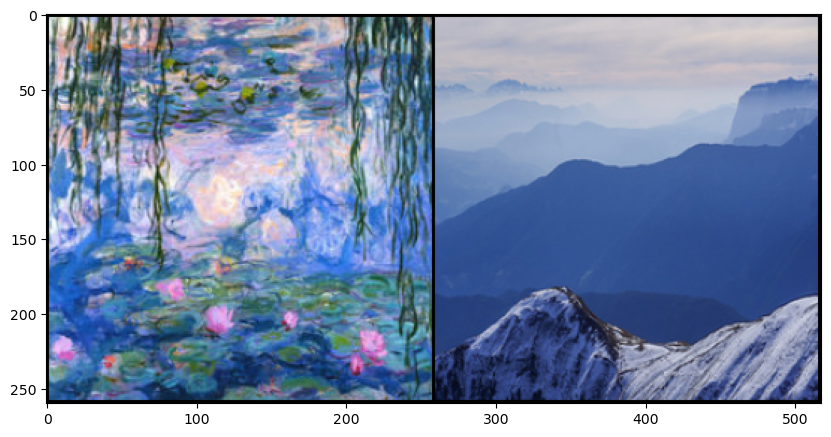

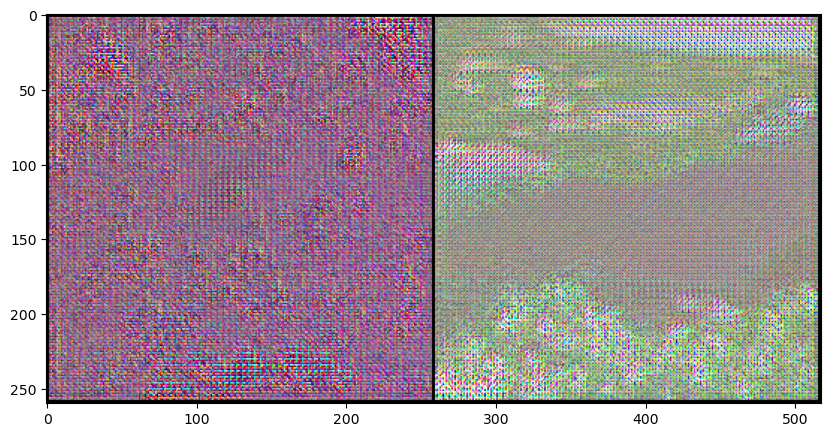

KeyboardInterrupt: 

In [223]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

# Turn true to save model
def train(save_model=save_model):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                generator_loss.append(mean_generator_loss)
                discriminator_loss.append(mean_discriminator_loss)
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_v1_{cur_step}.pth")

                    df = pd.DataFrame([generator_loss, discriminator_loss, [cur_step]]) 
                    df.to_csv(loss_path, index=False)
            cur_step += 1
train()